# Coding Assignment 5

Group Members:
Zubair Lalani (zubairl2)
Adithya Swaminathan (adithya9)

## Setup

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gap_statistic import OptimalK

ModuleNotFoundError: No module named 'gap_statistic'

## Problem 1


Read the data and one-hot encode Gender predictor

In [15]:
DATA_PATH = "data/problem1/Mall_Customers.csv"
df = pd.read_csv(DATA_PATH)
df = df.rename(columns={"Genre": "Gender"}) # Fix misspelling of the column name in the original data
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [55]:
df = pd.get_dummies(df, columns=["Gender"])
df["Gender_Female"] = df["Gender_Female"].astype(int)
df["Gender_Male"] = df["Gender_Male"].astype(int)
df.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,0,1
1,2,21,15,81,0,1
2,3,20,16,6,1,0
3,4,23,16,77,1,0
4,5,31,17,40,1,0


In [56]:
df.dtypes

CustomerID                int64
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
Gender_Female             int64
Gender_Male               int64
dtype: object

Scale the features in our dataset and remove unnecessary columns

In [57]:
features_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

X = df[features_cols] # removes CustomerID since we don't need it for our purposes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 1.A

Calculate optimal number of clusters use the Sillhoutte score

In [58]:
sil_scores = {}
k_values = range(2, 10)

for k in k_values:
    # setting n_init to avoid a warning
    # set random_state for reproducibility
    # try diff k for n_clusters and compare results using sillhoutte score
    kmeans = KMeans(n_clusters=k, random_state=207, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores[k] = score
    print(f"k = {k}, silhouette score = {score:.4f}")

# k with best silhouette
ksil = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", ksil)

k = 2, silhouette score = 0.3355
k = 3, silhouette score = 0.3578
k = 4, silhouette score = 0.4040
k = 5, silhouette score = 0.4166
k = 6, silhouette score = 0.4284
k = 7, silhouette score = 0.4179
k = 8, silhouette score = 0.4087
k = 9, silhouette score = 0.4186
Best k by silhouette: 6


Use the following open source library to calculate the optimal number of clusters using the gap statistics:

https://github.com/milesgranger/gap_statistic

In [59]:
optimalK = OptimalK(n_jobs=1, parallel_backend="joblib", random_state=598)
kgap = optimalK(X_scaled, cluster_array=k_values)

print("Optimal k by Gap Statistic (kgap):", kgap)

Optimal k by Gap Statistic (kgap): 8


In [60]:
optimalK.gap_df

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,2.0,0.162742,16.524538,0.034803,82.451545,97.100070,-0.236394,108.559686
1,3.0,0.437691,15.397084,0.038555,163.361704,189.469845,-0.070101,187.943636
2,4.0,0.556951,15.202655,0.049159,153.286812,177.868743,0.060874,172.759039
3,5.0,0.524542,7.432412,0.028466,124.212191,143.684419,0.034923,142.609196
4,6.0,0.555256,15.079455,0.065637,111.332247,129.729252,0.072314,126.532103
5,7.0,0.534580,10.296735,0.051638,94.059210,109.259066,-0.048346,108.526562
6,8.0,0.620403,6.435724,0.037477,91.837345,106.304697,0.103804,104.722491
7,9.0,0.571233,8.576948,0.054633,79.863058,92.748204,NaN,NaN


In [61]:
kmeans_gap = KMeans(n_clusters=kgap, random_state=598, n_init=10)
df["cluster_gap"] = kmeans_gap.fit_predict(X_scaled)

# Silhouette k
kmeans_sil = KMeans(n_clusters=ksil, random_state=598, n_init=10)
df["cluster_sil"] = kmeans_sil.fit_predict(X_scaled)

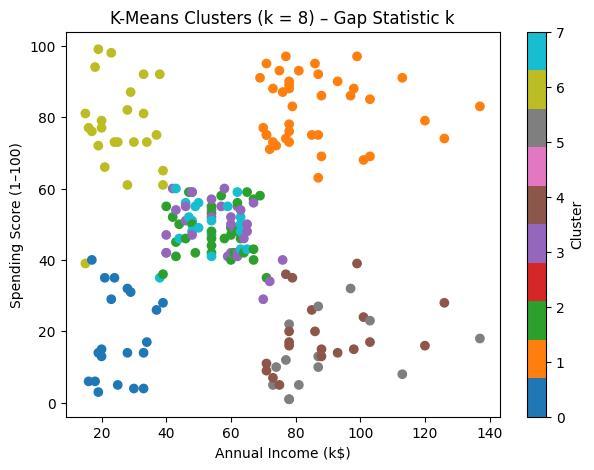

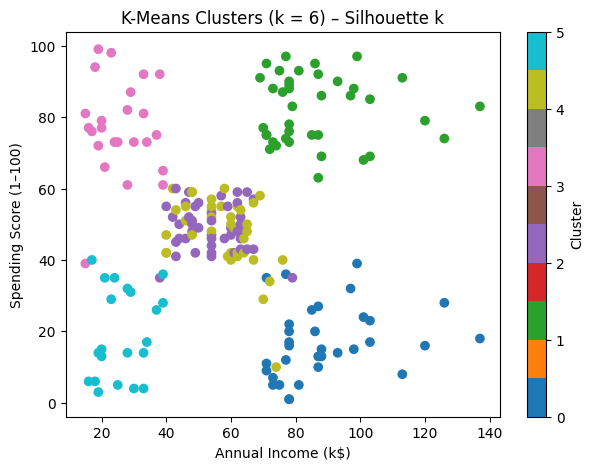

In [62]:
def plot_clusters(df, cluster_col, k, title_suffix):
    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(
        df["Annual Income (k$)"],
        df["Spending Score (1-100)"],
        c=df[cluster_col],
        cmap="tab10"
    )
    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1–100)")
    plt.title(f"K-Means Clusters (k = {k}) – {title_suffix}")
    plt.colorbar(scatter, label="Cluster")
    plt.show()

plot_clusters(df, "cluster_gap", kgap, "Gap Statistic k")
plot_clusters(df, "cluster_sil", ksil, "Silhouette k")

Based on the given plot, the clusters are split relatively well. There are a few clusteres that are a bit intermingled, especially in the middle, however that may be due to the fact that we are only looking at Annual Income and Spending score. 

In [63]:
summary_gap = (
    df.groupby("cluster_gap")[["Age",
                               "Annual Income (k$)",
                               "Spending Score (1-100)",
                               "Gender_Female",
                               "Gender_Male"]]
      .agg(["mean", "min", "max", "count"])
)

summary_gap

Age               Annual Income (k$)                 \
                  mean min max count               mean min  max count   
cluster_gap                                                              
0            45.400000  20  67    20          25.650000  16   39    20   
1            32.692308  27  40    39          86.538462  69  137    39   
2            47.093750  38  55    32          55.562500  39   71    32   
3            24.548387  18  34    31          56.322581  40   76    31   
4            49.000000  41  59    20          88.350000  71  126    20   
5            31.142857  19  40    14          89.285714  73  137    14   
6            25.250000  18  35    24          25.833333  15   39    24   
7            64.850000  57  70    20          53.150000  38   65    20   

            Spending Score (1-100)               Gender_Female                \
                              mean min max count          mean min max count   
cluster_gap                                                                    
0                        18.550000   3  40    20      0.650000   0   1    20   
1                        82.128205  63  97    39      0.538462   0   1    39   
2                        47.812500  35  59    32      0.656250   0   1    32   
3                        49.129032  29  60    31      0.645161   0   1    31   
4                        19.150000   5  39    20      0.550000   0   1    20   
5                        13.357143   1  32    14      0.285714   0   1    14   
6                        76.916667  39  99    24      0.583333   0   1    24   
7                        49.850000  35  60    20      0.400000   0   1    20   

            Gender_Male                
                   mean min max count  
cluster_gap                            
0              0.350000   0   1    20  
1              0.461538   0   1    39  
2              0.343750   0   1    32  
3              0.354839   0   1    31  
4              0.450000   0   1    20  
5              0.714286   0   1    14  
6              0.416667   0   1    24  
7              0.600000   0   1    20

In [64]:
summary_sil = (
    df.groupby("cluster_sil")[["Age",
                               "Annual Income (k$)",
                               "Spending Score (1-100)",
                               "Gender_Female",
                               "Gender_Male"]]
      .agg(["mean", "min", "max", "count"])
)
summary_sil

Age               Annual Income (k$)                 \
                  mean min max count               mean min  max count   
cluster_sil                                                              
0            41.939394  19  59    33          88.939394  71  137    33   
1            32.692308  27  40    39          86.538462  69  137    39   
2            56.333333  43  70    45          54.266667  38   79    45   
3            25.250000  18  35    24          25.833333  15   39    24   
4            26.684211  18  40    38          57.578947  40   76    38   
5            45.523810  20  67    21          26.285714  16   39    21   

            Spending Score (1-100)               Gender_Female                \
                              mean min max count          mean min max count   
cluster_sil                                                                    
0                        16.969697   1  39    33      0.424242   0   1    33   
1                        82.128205  63  97    39      0.538462   0   1    39   
2                        49.066667  35  60    45      0.577778   0   1    45   
3                        76.916667  39  99    24      0.583333   0   1    24   
4                        47.789474  10  60    38      0.631579   0   1    38   
5                        19.380952   3  40    21      0.619048   0   1    21   

            Gender_Male                
                   mean min max count  
cluster_sil                            
0              0.575758   0   1    33  
1              0.461538   0   1    39  
2              0.422222   0   1    45  
3              0.416667   0   1    24  
4              0.368421   0   1    38  
5              0.380952   0   1    21

### 1.B

## Problem 2

In [ ]:
np.random.seed(598)
n = 200
n_per_moon = n // 2 
r = 2  
noise_var = 0.05
noise_std = np.sqrt(noise_var)

1.

In [3]:
theta1 = np.random.uniform(0, np.pi, n_per_moon)

x1 = r * np.cos(theta1) + np.random.normal(0, noise_std, n_per_moon)
y1 = r * np.sin(theta1) + np.random.normal(0, noise_std, n_per_moon)

labels1 = np.zeros(n_per_moon, dtype=int)

2.

In [ ]:
theta2 = np.random.uniform(0, np.pi, n_per_moon)

x2 = 1 - 2 * np.cos(theta2) + np.random.normal(0, noise_std, n_per_moon)
y2 = -2 * np.sin(theta2) - 0.5 + np.random.normal(0, noise_std, n_per_moon)

labels2 = np.ones(n_per_moon, dtype=int)

3.

In [17]:
df = pd.DataFrame({
    "x": np.concatenate([x1, x2]),
    "y": np.concatenate([y1, y2]),
    "label": np.concatenate([labels1, labels2])
})

4.

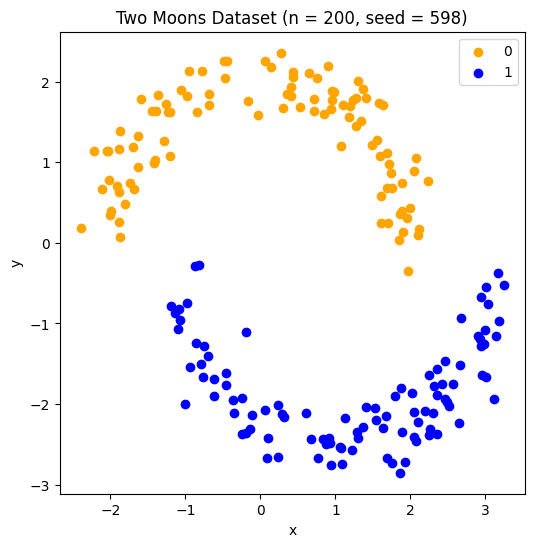

In [9]:
plt.figure(figsize=(6, 6))

plt.scatter(df[df["label"] == 0]["x"], df[df["label"] == 0]["y"], c='orange', label = '0')
plt.scatter(df[df["label"] == 1]["x"], df[df["label"] == 1]["y"], c='blue', label = '1')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Two Moons Dataset (n = 200, seed = 598)")
plt.legend()
plt.show()

K Means Clustering

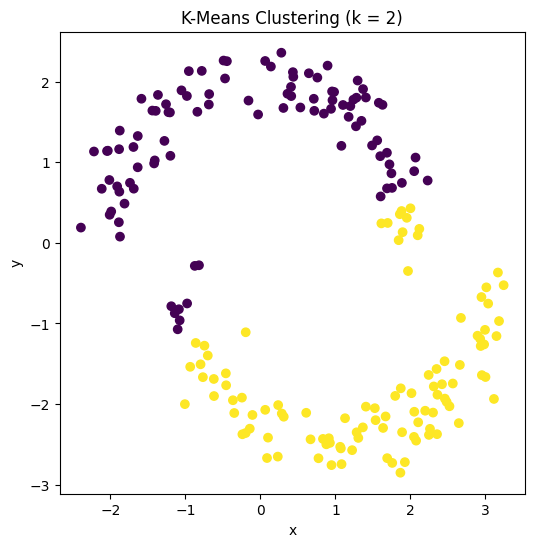

In [19]:
X = df[["x", "y"]].values
kmeans = KMeans(n_clusters=2, random_state=598, n_init=10)
df["kmeans_label"] = kmeans.fit_predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(df["x"], df["y"], c=df["kmeans_label"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("K-Means Clustering (k = 2)")
plt.show()

Spectral Clustering

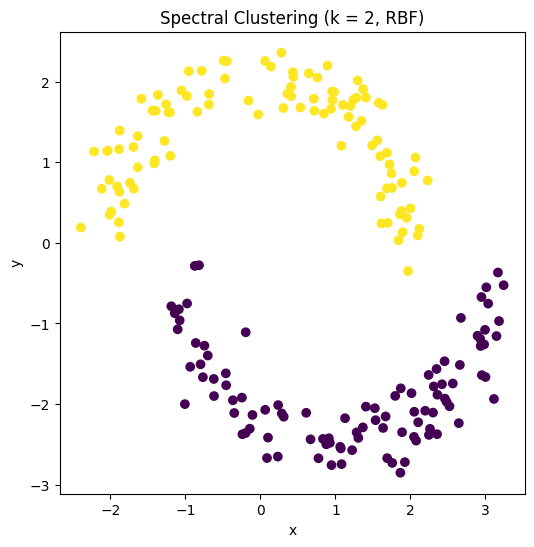

In [ ]:
spectral = SpectralClustering(
    n_clusters=2,
    affinity="rbf",  
    assign_labels="kmeans",
    random_state=598
)
df["spectral_label"] = spectral.fit_predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(df["x"], df["y"], c=df["spectral_label"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spectral Clustering (k = 2, RBF)")
plt.show()